<a href="https://colab.research.google.com/github/uxrkhan/action-recognition/blob/main/notebooks/lstm_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf sample_data
!git clone https://www.github.com/harvitronix/five-video-classification-methods.git
!mv five-video-classification-methods/* .
!rm -rf five-video-classification-methods

Cloning into 'five-video-classification-methods'...
remote: Enumerating objects: 495, done.
remote: Total 495 (delta 0), reused 0 (delta 0), pack-reused 495
Receiving objects: 100% (495/495), 322.37 KiB | 582.00 KiB/s, done.
Resolving deltas: 100% (289/289), done.


In [2]:
!rsync --progress drive/MyDrive/data_tar/sequences40.tar .
!tar xf sequences40.tar --checkpoint=.5000
!rm sequences40.tar
!mv sequences data
!echo

!rsync --progress drive/MyDrive/data_tar/test.tar .
!tar xf test.tar --checkpoint=.5000
!rm test.tar
!mv test data
!echo

!rsync --progress drive/MyDrive/data_tar/train.tar .
!tar xf train.tar --checkpoint=.10000
!rm train.tar
!mv train data

sequences40.tar
  3,930,644,480 100%   22.14MB/s    0:02:49 (xfr#1, to-chk=0/1)
............................................................................
test.tar
  5,118,146,560 100%   20.08MB/s    0:04:03 (xfr#1, to-chk=0/1)
...................................................................................................
train.tar
 13,107,425,280 100%   15.68MB/s    0:13:17 (xfr#1, to-chk=0/1)
................................................................................................................................

In [ ]:
!mkdir data/checkpoints
!mkdir data/logs

In [ ]:
!mv data/data_file.csv data/data_file_original.csv
!rsync -progress drive/MyDrive/data/data_file.csv data/data_file.csv

In [ ]:
"""
Class for managing our data.
"""
import csv
import numpy as np
import random
import glob
import os.path
import sys
import operator
import threading
from processor import process_image
from keras.utils import to_categorical
from tqdm import notebook as tqdm

class threadsafe_iterator:
    def __init__(self, iterator):
        self.iterator = iterator
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.iterator)

def threadsafe_generator(func):
    """Decorator"""
    def gen(*a, **kw):
        return threadsafe_iterator(func(*a, **kw))
    return gen

class DataSet():

    def __init__(self, seq_length=40, class_limit=None, image_shape=(224, 224, 3)):
        """Constructor.
        seq_length = (int) the number of frames to consider
        class_limit = (int) number of classes to limit the data to.
            None = no limit.
        """
        self.seq_length = seq_length
        self.class_limit = class_limit
        self.sequence_path = os.path.join('data', 'sequences')
        self.max_frames = 300  # max number of frames a video can have for us to use it

        # Get the data.
        self.data = self.get_data()

        # Get the classes.
        self.classes = self.get_classes()

        # Now do some minor data cleaning.
        self.data = self.clean_data()

        self.image_shape = image_shape

    @staticmethod
    def get_data():
        """Load our data from file."""
        with open(os.path.join('data', 'data_file.csv'), 'r') as fin:
            reader = csv.reader(fin)
            data = list(reader)

        return data

    def clean_data(self):
        """Limit samples to greater than the sequence length and fewer
        than N frames. Also limit it to classes we want to use."""
        data_clean = []
        for item in self.data:
            if int(item[3]) >= self.seq_length and int(item[3]) <= self.max_frames \
                    and item[1] in self.classes:
                data_clean.append(item)

        return data_clean

    def get_classes(self):
        """Extract the classes from our data. If we want to limit them,
        only return the classes we need."""
        classes = []
        for item in self.data:
            if item[1] not in classes:
                classes.append(item[1])

        # Sort them.
        classes = sorted(classes)

        # Return.
        if self.class_limit is not None:
            return classes[:self.class_limit]
        else:
            return classes

    def get_class_one_hot(self, class_str):
        """Given a class as a string, return its number in the classes
        list. This lets us encode and one-hot it for training."""
        # Encode it first.
        label_encoded = self.classes.index(class_str)

        # Now one-hot it.
        label_hot = to_categorical(label_encoded, len(self.classes))

        assert len(label_hot) == len(self.classes)

        return label_hot

    def split_train_test(self):
        """Split the data into train and test groups."""
        train = []
        test = []
        for item in self.data:
            if item[0] == 'train':
                train.append(item)
            else:
                test.append(item)
        return train, test

    def get_all_sequences_in_memory(self, train_test, data_type):
        """
        This is a mirror of our generator, but attempts to load everything into
        memory so we can train way faster.
        """
        # Get the right dataset.
        train, test = self.split_train_test()
        data = train if train_test == 'train' else test

        print("Loading %d samples into memory for %sing." % (len(data), train_test))

        X, y = [], []
        pbar = tqdm.tqdm(total=len(data))
        for row in data:

            if data_type == 'images':
                frames = self.get_frames_for_sample(row)
                frames = self.rescale_list(frames, self.seq_length)

                # Build the image sequence
                sequence = self.build_image_sequence(frames)

            else:
                sequence = self.get_extracted_sequence(data_type, row)

                if sequence is None:
                    print("Can't find sequence. Did you generate them?")
                    raise

            X.append(sequence)
            y.append(self.get_class_one_hot(row[1]))
            pbar.update(1)
        pbar.close()

        return np.array(X), np.array(y)

    @threadsafe_generator
    def frame_generator(self, batch_size, train_test, data_type):
        """Return a generator that we can use to train on. There are
        a couple different things we can return:

        data_type: 'features', 'images'
        """
        # Get the right dataset for the generator.
        train, test = self.split_train_test()
        data = train if train_test == 'train' else test

        print("Creating %s generator with %d samples." % (train_test, len(data)))

        while 1:
            X, y = [], []

            # Generate batch_size samples.
            for _ in range(batch_size):
                # Reset to be safe.
                sequence = None

                # Get a random sample.
                sample = random.choice(data)

                # Check to see if we've already saved this sequence.
                if data_type is "images":
                    # Get and resample frames.
                    frames = self.get_frames_for_sample(sample)
                    frames = self.rescale_list(frames, self.seq_length)

                    # Build the image sequence
                    sequence = self.build_image_sequence(frames)
                else:
                    # Get the sequence from disk.
                    sequence = self.get_extracted_sequence(data_type, sample)

                    if sequence is None:
                        raise ValueError("Can't find sequence. Did you generate them?")

                X.append(sequence)
                y.append(self.get_class_one_hot(sample[1]))

            yield np.array(X), np.array(y)

    def build_image_sequence(self, frames):
        """Given a set of frames (filenames), build our sequence."""
        return [process_image(x, self.image_shape) for x in frames]

    def get_extracted_sequence(self, data_type, sample):
        """Get the saved extracted features."""
        filename = sample[2]
        path = os.path.join(self.sequence_path, filename + '-' + str(self.seq_length) + \
            '-' + data_type + '.npy')
        if os.path.isfile(path):
            return np.load(path)
        else:
            return None

    def get_frames_by_filename(self, filename, data_type):
        """Given a filename for one of our samples, return the data
        the model needs to make predictions."""
        # First, find the sample row.
        sample = None
        for row in self.data:
            if row[2] == filename:
                sample = row
                break
        if sample is None:
            raise ValueError("Couldn't find sample: %s" % filename)

        if data_type == "images":
            # Get and resample frames.
            frames = self.get_frames_for_sample(sample)
            frames = self.rescale_list(frames, self.seq_length)
            # Build the image sequence
            sequence = self.build_image_sequence(frames)
        else:
            # Get the sequence from disk.
            sequence = self.get_extracted_sequence(data_type, sample)

            if sequence is None:
                raise ValueError("Can't find sequence. Did you generate them?")

        return sequence

    @staticmethod
    def get_frames_for_sample(sample):
        """Given a sample row from the data file, get all the corresponding frame
        filenames."""
        path = os.path.join('data', sample[0], sample[1])
        filename = sample[2]
        images = sorted(glob.glob(os.path.join(path, filename + '*jpg')))
        return images

    @staticmethod
    def get_filename_from_image(filename):
        parts = filename.split(os.path.sep)
        return parts[-1].replace('.jpg', '')

    @staticmethod
    def rescale_list(input_list, size):
        """Given a list and a size, return a rescaled/samples list. For example,
        if we want a list of size 5 and we have a list of size 25, return a new
        list of size five which is every 5th element of the origina list."""
        assert len(input_list) >= size

        # Get the number to skip between iterations.
        skip = len(input_list) // size

        # Build our new output.
        output = [input_list[i] for i in range(0, len(input_list), skip)]

        # Cut off the last one if needed.
        return output[:size]

    def print_class_from_prediction(self, predictions, nb_to_return=5):
        """Given a prediction, print the top classes."""
        # Get the prediction for each label.
        label_predictions = {}
        for i, label in enumerate(self.classes):
            label_predictions[label] = predictions[i]

        # Now sort them.
        sorted_lps = sorted(
            label_predictions.items(),
            key=operator.itemgetter(1),
            reverse=True
        )

        # And return the top N.
        for i, class_prediction in enumerate(sorted_lps):
            if i > nb_to_return - 1 or class_prediction[1] == 0.0:
                break
            print("%s: %.2f" % (class_prediction[0], class_prediction[1]))


In [ ]:
# TRAIN 

from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, Callback
from models import ResearchModels
import time
import os.path

def train(data_type, seq_length, model, saved_model=None,
          class_limit=None, image_shape=None,
          load_to_memory=False, batch_size=32, nb_epoch=100):
    # Helper: Save the model.
    checkpointer = ModelCheckpoint(
        filepath=os.path.join('data', 'checkpoints', model + '-' + data_type + \
            '.{epoch:03d}-{val_loss:.3f}.hdf5'),
        verbose=1,
        save_best_only=True)
    
    # Helper: TensorBoard
    tb = TensorBoard(log_dir=os.path.join('data', 'logs', model))

    # Helper: Stop when we stop learning.
    early_stopper = EarlyStopping(patience=8)

    # Helper: Save results.
    timestamp = time.time()
    csv_logger = CSVLogger(os.path.join('data', 'logs', model + '-' + 'training-' + \
        str(timestamp) + '.log'))

    # Get the data and process it.
    if image_shape is None:
        data = DataSet(
            seq_length=seq_length,
            class_limit=class_limit
        )
    else:
        data = DataSet(
            seq_length=seq_length,
            class_limit=class_limit,
            image_shape=image_shape
        )

    # Get samples per epoch.
    # Multiply by 0.7 to attempt to guess how much of data.data is the train set.
    steps_per_epoch = (len(data.data) * 0.7) // batch_size
    print("Length of data: " + str(len(data.data)))
    print("Steps per epoch: " + str(steps_per_epoch))

    if load_to_memory:
        # Get data.
        X, y = data.get_all_sequences_in_memory('train', data_type)
        X_test, y_test = data.get_all_sequences_in_memory('test', data_type)
    else:
        # Get generators.
        generator = data.frame_generator(batch_size, 'train', data_type)
        val_generator = data.frame_generator(batch_size, 'test', data_type)

    # Get the model.
    rm = ResearchModels(len(data.classes), model, seq_length, saved_model)

    # Fit!
    if load_to_memory:
        # Use standard fit.
        rm.model.fit(
            X,
            y,
            batch_size=batch_size,
            validation_data=(X_test, y_test),
            verbose=1,
            callbacks=[tb, early_stopper, csv_logger, checkpointer],
            epochs=nb_epoch)
    else:
        # Use fit generator.
        rm.model.fit_generator(
            generator=generator,
            steps_per_epoch=steps_per_epoch,
            epochs=nb_epoch,
            verbose=1,
            callbacks=[tb, early_stopper, csv_logger, checkpointer],
            validation_data=val_generator,
            validation_steps=40,
            workers=4)
        
    return rm.model

# model can be one of lstm, lrcn, mlp, conv_3d, c3d
model = 'lstm'
saved_model = None #  None or weights file
class_limit = None  # int, can be 1-101 or None
seq_length = 40
load_to_memory = True  # pre-load the sequences into memory
batch_size = 32
nb_epoch = 1000

# Chose images or features and image shape based on network.
if model in ['conv_3d', 'c3d', 'lrcn']:
    data_type = 'images'
    image_shape = (80, 80, 3)
elif model in ['lstm', 'mlp']:
    data_type = 'features'
    image_shape = None
else:
    raise ValueError("Invalid model. See train.py for options.")

trained_model = train(data_type, seq_length, model, saved_model=saved_model,
      class_limit=class_limit, image_shape=image_shape,
      load_to_memory=load_to_memory, batch_size=batch_size, nb_epoch=nb_epoch)

Length of data: 11958
Steps per epoch: 261.0
Loading 8573 samples into memory for training.



Loading 3385 samples into memory for testing.



Loading LSTM model.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2048)              33562624  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               51813     
Total params: 34,663,525
Trainable params: 34,663,525
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
268/268 [==============================] - 40s 121ms/step - loss: 4.5055 - accuracy: 0.0455 - top_k_categorical_accuracy: 0.1402 - val_loss: 3.6022 - val_accuracy: 0.3510 - val_top_k_categorical_accuracy

In [ ]:
!rm data/checkpoints/lstm-features.010-1.106.hdf5

In [ ]:
!cd data/ && zip -r logger5-lstm.zip logs
!cd data/ && zip -r logger5-lstm.zip checkpoints

  adding: logs/ (stored 0%)
  adding: logs/lstm/ (stored 0%)
  adding: logs/lstm/train/ (stored 0%)
  adding: logs/lstm/train/events.out.tfevents.1612157234.d298a1cba66e.profile-empty (deflated 5%)
  adding: logs/lstm/train/events.out.tfevents.1612157226.d298a1cba66e.761.617.v2 (deflated 88%)
  adding: logs/lstm/train/plugins/ (stored 0%)
  adding: logs/lstm/train/plugins/profile/ (stored 0%)
  adding: logs/lstm/train/plugins/profile/2021_02_01_05_27_14/ (stored 0%)
  adding: logs/lstm/train/plugins/profile/2021_02_01_05_27_14/d298a1cba66e.memory_profile.json.gz (stored 0%)
  adding: logs/lstm/train/plugins/profile/2021_02_01_05_27_14/d298a1cba66e.xplane.pb (deflated 80%)
  adding: logs/lstm/train/plugins/profile/2021_02_01_05_27_14/d298a1cba66e.overview_page.pb (deflated 55%)
  adding: logs/lstm/train/plugins/profile/2021_02_01_05_27_14/d298a1cba66e.trace.json.gz (deflated 0%)
  adding: logs/lstm/train/plugins/profile/2021_02_01_05_27_14/d298a1cba66e.kernel_stats.pb (deflated 93%)
  a

In [ ]:
!rsync --progress data/logger5-lstm.zip drive/MyDrive/write_data/

logger5-lstm.zip
    385,189,744 100%  165.76MB/s    0:00:02 (xfr#1, to-chk=0/1)


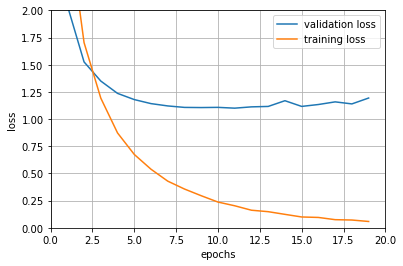

In [ ]:
import sys
import csv
import matplotlib.pyplot as plt

training_log = '/content/data/logs/lstm-training-1612157132.6753058.log'

validation_accuracies = []
validation_loss = []
training_accuracies = []
training_loss = []
validation_top_k_acc = []
training_top_k_acc = []

with open(training_log) as fin:
    reader = csv.reader(fin)
    next(reader, None)  # skip the header
    for epoch,acc,loss,top_k_categorical_accuracy,val_acc,val_loss,val_top_k_categorical_accuracy in reader:
        validation_accuracies.append(float(val_acc))
        validation_loss.append(float(val_loss))
        training_loss.append(float(loss))
        training_accuracies.append(float(acc))
        training_top_k_acc.append(float(top_k_categorical_accuracy))
        validation_top_k_acc.append(float(val_top_k_categorical_accuracy))

plt.plot(validation_loss, label='validation loss')
plt.plot(training_loss, label='training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim((0,2))
plt.xlim((0, len(training_loss)))
plt.legend()
plt.grid()
plt.savefig('lstm-metrics-plot-loss.jpg')
plt.show()

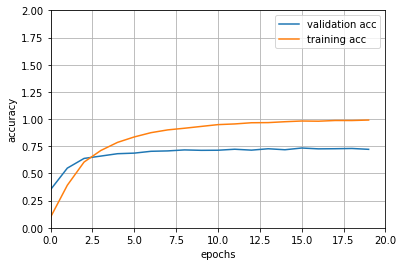

In [ ]:
plt.plot(validation_accuracies, label='validation acc')
plt.plot(training_accuracies, label='training acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim((0,2))
plt.xlim((0, len(training_accuracies)))
plt.legend()
plt.grid()
plt.savefig('lstm-metrics-plot-acc.jpg')
plt.show()

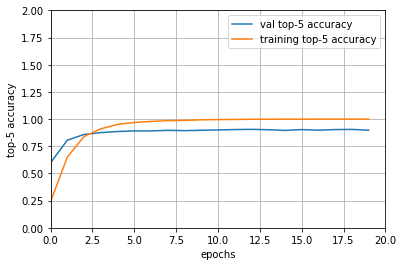

In [ ]:
plt.plot(validation_top_k_acc, label='val top-5 accuracy')
plt.plot(training_top_k_acc, label='training top-5 accuracy')
plt.xlabel('epochs')
plt.ylabel('top-5 accuracy')
plt.ylim((0,2))
plt.xlim((0, len(training_top_k_acc)))
plt.legend()
plt.grid()
plt.savefig('lstm-metrics-plot-top-5-cat.jpg')
plt.show()

In [ ]:
import google.colab.files as files
files.download("lstm-metrics-plot-top-5-cat.jpg")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from keras.callbacks import TensorBoard, ModelCheckpoint, CSVLogger
from models import ResearchModels

model = 'lstm'
saved_model = 'data/checkpoints/lstm-features.012-1.100.hdf5'
data_type = 'features'
image_shape = None
class_limit = None

batch_size = 32

# Get the data and process it.
data = DataSet(seq_length=seq_length, class_limit=class_limit)

# Get the model.
# rm = ResearchModels(len(data.classes), model, seq_length, saved_model)
rm = ResearchModels(len(data.classes), model, seq_length, saved_model)

# Evaluate!
# val_generator = data.frame_generator(batch_size, 'test', data_type)
# results = rm.model.evaluate(x=val_generator, steps=3200)

Loading model data/checkpoints/lstm-features.012-1.100.hdf5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2048)              33562624  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               51813     
Total params: 34,663,525
Trainable params: 34,663,525
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
X_test, y_test = data.get_all_sequences_in_memory('test', data_type)
# results = rm.model.evaluate(x=X_test, y=y_test, batch_size=32)

# print(results)
# print(rm.model.metrics_names)

predictions = rm.model.predict(x=X_test, batch_size=32)
cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

Loading 3385 samples into memory for testing.


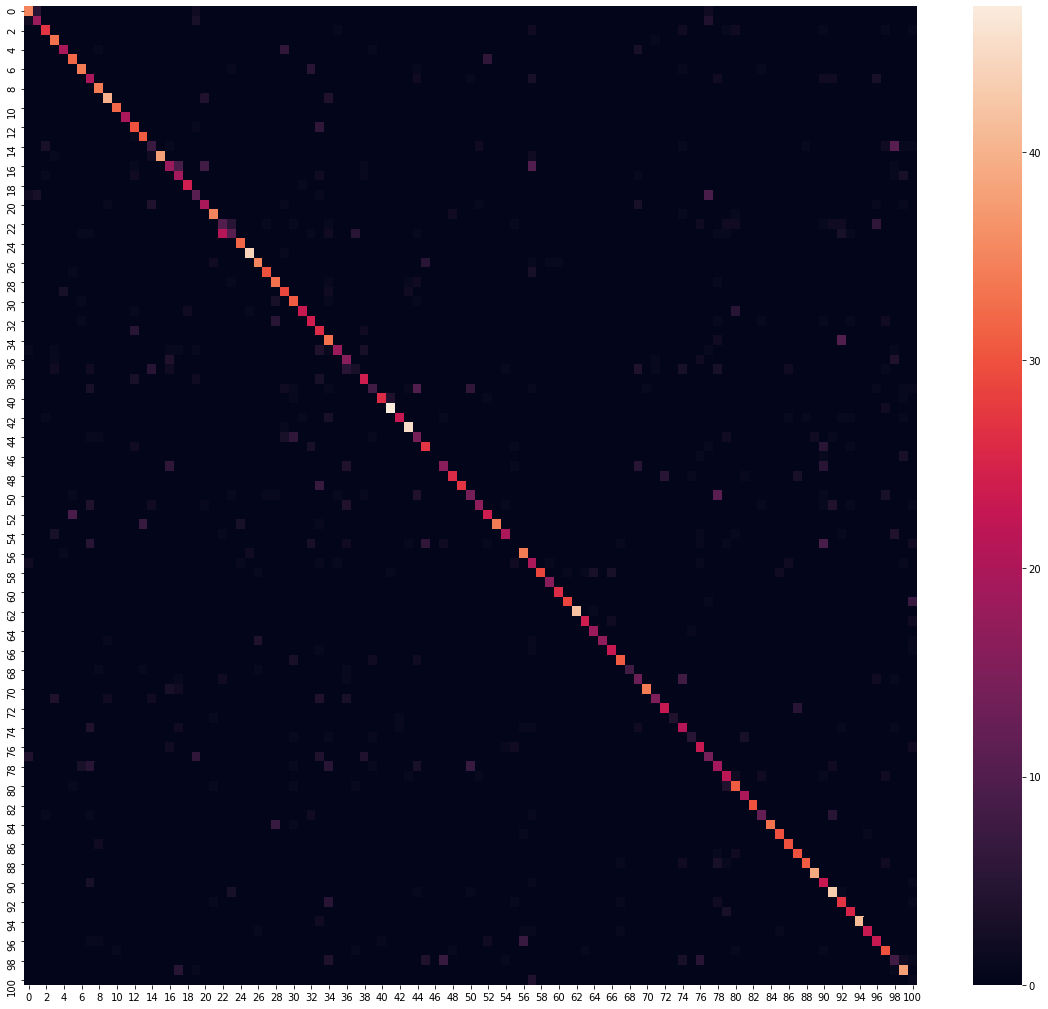

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd

nb_classes = len(data.classes)
df_cm = pd.DataFrame(cm, index=range(nb_classes), columns=range(nb_classes))
plt.figure(figsize = (20,18))
sn.heatmap(df_cm, linewidths=0, annot=False)

In [ ]:
!rsync --progress drive/MyDrive/write_data/logger5-lstm.zip .
!unzip logger5-lstm.zip -d logger5
!mv logger5/checkpoints/* .

In [ ]:
# DEMO SCRIPT - MAKING IT WORK ON EXTERNAL VIDEO 

from keras.models import load_model
from data import DataSet
import numpy as np

saved_model = 'lstm-features.012-1.100.hdf5'
image_shape = None
data_type = 'features'
seq_length = 40

video_name = 'v_Archery_g04_c02'

print('Getting model...')
model = load_model(saved_model)
print('Model loaded.')

data = DataSet(seq_length=seq_length)
feature_frames = data.get_frames_by_filename(video_name, data_type)
prediction = model.predict(np.expand_dims(feature_frames, axis=0))
data.print_class_from_prediction(np.squeeze(prediction, axis=0))

Getting model...
Model loaded.
Archery: 0.99
Swing: 0.00
JumpingJack: 0.00
TaiChi: 0.00
HulaHoop: 0.00


In [ ]:
!ls drive/MyDrive/write_data/checkpoints

lstm-features.001-1.780.hdf5  lstm-features.006-1.008.hdf5
lstm-features.002-1.321.hdf5  lstm-features.007-1.006.hdf5
lstm-features.003-1.147.hdf5  lstm-features.008-0.972.hdf5
lstm-features.004-1.060.hdf5  lstm-features.009-0.965.hdf5
lstm-features.005-1.012.hdf5  lstm-features.010-0.959.hdf5


In [ ]:
from keras.models import load_model, Model
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from data import DataSet
import numpy as np
import os
import cv2

class newExtractor():
  def __init__(self, weights=None):
    self.weights = weights  
    if weights is None:
      base_model = InceptionV3(
        weights='imagenet',
        include_top=True
      )
      self.model = Model(
        inputs=base_model.input,
        outputs=base_model.get_layer('avg_pool').output
      )

    else:
      # self.model = load_model(weights)
      # self.model._layers.pop()
      # self.model._layers.pop()  
      # self.model.outputs = [self.model.layers[-1].output]
      # self.model.output_layers = [self.model.layers[-1]]
      # self.model._layers[-1].outbound_nodes = []
      base_model = load_model(weights)
      self.model = Model(
          inputs=base_model.input,
          outputs=base_model.get_layer('global_average_pooling2d').output
      )

  def extract(self, img):
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)
    features = self.model.predict(x)
    features = features[0]
    return features

def rescale_list(input_list, size, two_way_rescale = False):
  if len(input_list) >= size:
    skip = len(input_list) // size
    output = [input_list[i] for i in range(0, len(input_list), skip)]
    return output[:size]
  elif two_way_rescale == True:
    # Build our new output.                
    append_list = []
    for i in range(size - len(input_list)):
      append_list.append(input_list[random.randint(0,len(input_list)-1)])
    # Merge two lists.        
    output = append_list+input_list
    return output

print('Creating CNN feature extractor...')
extractor = newExtractor(weights='inception.013-1.11.hdf5')
print('Created extractor.')

saved_model = 'lstm-features.012-1.100.hdf5'
image_shape = None
data_type = 'features'
seq_length = 40

# video_name = 'v_Archery_g04_c02'
video_name = 'data/test/Archery/v_Archery_g06_c01.avi'

print('Getting model...')
model = load_model(saved_model)
print('Model loaded.')  
  
# # check if the sequences exists
# feature_frames = None
# path = os.path.join('data/sequences/' + video_name + '-' + str(seq_length) + '-features.npy')
# if os.path.isfile(path):
#     print('load existing sequence...')
#     feature_frames = np.load(path)
# else:
#     print('generating sequence...')
#     videoCapture = cv2.VideoCapture(video_name)
#     success, frame = videoCapture.read()
#     sequence = []
#     while success:
#         frame = cv2.resize(frame, (299, 299))
#         frame = image.img_to_array(frame)
#         # extract features
#         features = extractor.extract(frame)
#         sequence.append(features)
#         success, frame = videoCapture.read()
#     # rescale our sequences
#     sequence = rescale_list(sequence, seq_length)
#     np.save(path, sequence)     
#     feature_frames = sequence

print('Generating feature sequence...')
videoCapture = cv2.VideoCapture(video_name)
success, frame = videoCapture.read()
sequence = []
while success:
    frame = cv2.resize(frame, (299, 299))
    frame = image.img_to_array(frame)
    # extract features
    features = extractor.extract(frame)
    sequence.append(features)
    success, frame = videoCapture.read()
# rescale our sequences
sequence = rescale_list(sequence, seq_length)
# np.save(path, sequence)     
feature_frames = sequence

print('Predicting...')
prediction = model.predict(np.expand_dims(feature_frames, axis=0))
print('Prediction complete.\n--------------')
data.print_class_from_prediction(np.squeeze(prediction, axis=0))

Creating CNN feature extractor...
Created extractor.
Getting model...
Model loaded.
generating sequence...
Predicting...
Prediction complete.
--------------
YoYo: 0.95
PlayingDaf: 0.01
Drumming: 0.00
PizzaTossing: 0.00
CliffDiving: 0.00


Pred class = JumpRope 
Acc = 0.68
Prediction time = 0.057 s
Total time = 0.075 s


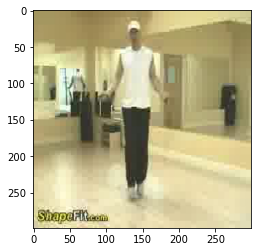

In [ ]:
# Testing CNN on random images

from data import DataSet
from processor import process_image
import glob
import random
import time
import operator
import numpy as np
import matplotlib.pyplot as plt

data = DataSet()
model = load_model('inception.013-1.11.hdf5')
images = glob.glob(os.path.join('data', 'test', '**', '*.jpg'))

sample_idx = random.randint(0, len(images) - 1)
image = images[sample_idx]

i_start_time = time.time()

image_arr = process_image(image, (299, 299, 3))
plt.imshow(image_arr)
image_arr = np.expand_dims(image_arr, axis=0)

p_start_time = time.time()

predictions = model.predict(image_arr)

end_time = time.time()

labelled_preds = {}
for i, class_name in enumerate(data.classes):
  labelled_preds[class_name] = predictions[0][i]

sorted_labelled_preds = sorted(labelled_preds.items(), key=operator.itemgetter(1), reverse=True)
print("Pred class = %s \nAcc = %.2f" %  (sorted_labelled_preds[0][0], sorted_labelled_preds[0][1]))
print("Prediction time = %.3f s" % (end_time - p_start_time))
print("Total time = %.3f s" % (end_time - i_start_time))

In [1]:
!rsync --progress drive/MyDrive/write_data/saved_models/* .

inception.013-1.11.hdf5
    170,769,992 100%   97.38MB/s    0:00:01 (xfr#1, to-chk=1/2)
lstm-features.012-1.100.hdf5
    415,999,288 100%   84.21MB/s    0:00:04 (xfr#2, to-chk=0/2)


In [3]:
from keras.models import load_model, Model
xmodel = load_model('inception.013-1.11.hdf5')

In [20]:
xmodel.layers[-3:]

In [31]:
newmodel = Model(inputs=xmodel.input, outputs=xmodel.layers[-3].output)

In [33]:
print(len(xmodel.layers))
print(len(newmodel.layers))

314
312


In [29]:
xmodel.layers[-3].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'global_average_pooling2d')>

In [ ]:
# function ConnectButton(){
#     console.log("Connect pushed"); 
#     document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
# }
# setInterval(ConnectButton,60000);